# Novel molecule discovery with mass spectrometry

[Mass spectrometry](https://en.wikipedia.org/wiki/Mass_spectrometry) is a powerful technique for the analysis of biological and chemical samples. In the [Ingalls Lab](https://sites.google.com/view/anitra-ingalls/home?authuser=0), we use it to detect and quantify the biochemical composition of seawater and the organisms that live in it. Other labs use similar techniques to [find new biocatalysts](https://bsmoore.scrippsprofiles.ucsd.edu/moore-lab-research/), [iron-binding siderophores](https://www.bundylab.com/projects), or [life-giving lipids](https://www2.whoi.edu/staff/bvanmooy/projects/marine-environmental-lipidomics/).

Mass spectrometry data is being increasingly deposited into online repositories for reproducibility and reuse. The two largest repos for metabolomics data are [Metabolights](https://www.ebi.ac.uk/metabolights/) and [Metabolomics Workbench](https://www.metabolomicsworkbench.org/), both of which have raw MS data available for download. In this demo I'll be using files from a [prior study done in the Ingalls lab](https://www.sciencedirect.com/science/article/pii/S1434461018301184) that's since been [posted to Metabolights](https://www.ebi.ac.uk/metabolights/editor/MTBLS708/samples). I'll also be using our lab's [custom MS Python library `pylgrams`](https://github.com/wkumler/pylgrams) to open and view the MS files.

In [2]:
!pip install pylgrams

Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement pylgrams (from versions: none)
ERROR: No matching distribution found for pylgrams


In [2]:
# Load packages
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import pylgrams

In [3]:
# Get the data from the web
os.mkdir("mzXML_data")
!wget -O mzXML_data/161024_Smp_LB12HL_AB_pos.mzXML https://www.ebi.ac.uk/metabolights/ws/studies/MTBLS708/download/2dfa2656-ec75-4fe0-96ac-6b74f295b3e9?file=FILES/161024_Smp_LB12HL_AB_pos.mzXML
!wget -O mzXML_data/161024_Smp_LB12HL_CD_pos.mzXML https://www.ebi.ac.uk/metabolights/ws/studies/MTBLS708/download/2dfa2656-ec75-4fe0-96ac-6b74f295b3e9?file=FILES/161024_Smp_LB12HL_CD_pos.mzXML
!wget -O mzXML_data/161024_Smp_LB12HL_EF_pos.mzXML https://www.ebi.ac.uk/metabolights/ws/studies/MTBLS708/download/2dfa2656-ec75-4fe0-96ac-6b74f295b3e9?file=FILES/161024_Smp_LB12HL_EF_pos.mzXML

--2024-08-13 21:16:44--  https://www.ebi.ac.uk/metabolights/ws/studies/MTBLS708/download/2dfa2656-ec75-4fe0-96ac-6b74f295b3e9?file=FILES/161024_Smp_LB12HL_AB_pos.mzXML
Resolving www.ebi.ac.uk (www.ebi.ac.uk)... 193.62.193.80
Connecting to www.ebi.ac.uk (www.ebi.ac.uk)|193.62.193.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46779755 (45M) [application/octet-stream]
Saving to: ‘mzXML_data/161024_Smp_LB12HL_AB_pos.mzXML’

mzXML_data/161024_S 100%[===================>]  44.61M  13.6MB/s    in 3.4s    

2024-08-13 21:16:47 (13.2 MB/s) - ‘mzXML_data/161024_Smp_LB12HL_AB_pos.mzXML’ saved [46779755/46779755]

--2024-08-13 21:16:47--  https://www.ebi.ac.uk/metabolights/ws/studies/MTBLS708/download/2dfa2656-ec75-4fe0-96ac-6b74f295b3e9?file=FILES/161024_Smp_LB12HL_CD_pos.mzXML
Resolving www.ebi.ac.uk (www.ebi.ac.uk)... 193.62.193.80
Connecting to www.ebi.ac.uk (www.ebi.ac.uk)|193.62.193.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49

In [4]:
# Read the data into Python
msdata = pylgrams.grabMSdata(["mzXML_data/161024_Smp_LB12HL_AB_pos.mzXML", "mzXML_data/161024_Smp_LB12HL_CD_pos.mzXML", "mzXML_data/161024_Smp_LB12HL_EF_pos.mzXML"])

100%|██████████| 3/3 [00:03<00:00,  1.11s/it]

Total time: 3.33 seconds


Mass spectrometry data is typically paired with some kind of [chromatography](https://en.wikipedia.org/wiki/Chromatography), a method that separates compounds by their stickiness. Chromatography looks at the abundance of a sample as it elutes from a column or off of a plate and provides a trace of how abundant molecules were in the sample across time. We can see this 2-D representation of our samples in a "base peak chromatogram" that shows the the intensity of the signal measured by the instrument across time.

The `msdata` object returned by the `grabMSdata` function is a list of Pandas data frames. One of these is named "BPC" for "base peak chromatogram" and contains three columns - one for the retention time (rt), another for signal intensity (int), and a final one for filename.

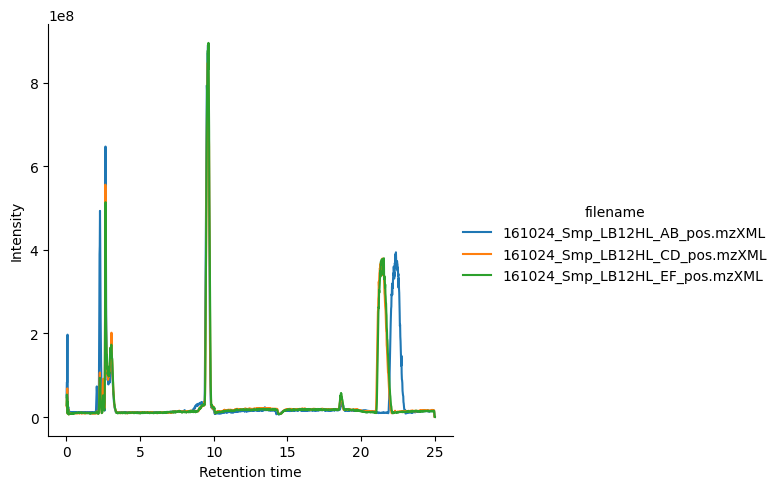

In [5]:
# Plot the chromatography-only trace (BPC)
bpcplot = sns.relplot(msdata["BPC"], kind="line", x="rt", y="int", hue="filename")
bpcplot.set_axis_labels("Retention time", "Intensity")
print(bpcplot)

Individual molecules here show up as mountains or "peaks" that generally have a nice bell-curve shape. In the plot above, I see perhaps 6 or 7 molecules appearing above a baseline level of noise. However, the chromatography alone doesn't give us very much information about what the identity of these molecules could be. For that, we turn to mass spectrometry.

Mass spectrometry is commonly paired with chromatography because it's able to take individual droplets of the sample as it emerges from the column and measure the mass (more specifically, the mass-to-charge ratio) of each compound. This adds an additional dimension to our analysis, converting the 2D chromatogram into a 3D landscape of peaks at varying masses.

![manual_ridge_vis.png](https://github.com/wkumler/reproducible_codfish/blob/main/manual_ridges_msspace/manual_ridge_vis.png?raw=true)

The figure above I stole from a previous visualization I did (R code available [here](https://github.com/wkumler/reproducible_codfish/tree/main/manual_ridges_msspace)) so it's not exactly the same as the files we have currently loaded but the intuition is the same. You can also see that I've manually identified a few of our known molecules but that there are other signals there for which we don't know the associated chemical identity.

### Targeted MS techniques

Mass spectrometry methods typically break down into two general approaches. The first method, targeted MS, starts with a list of molecules that the researcher expects to find in the sample. For example, all life on the planet uses nucleobases to build DNA and RNA so a researcher could reasonably expect to find these molecules in their environmental sample. To check, we can look up the masses of these molecules in an online database like [Pubchem](https://pubchem.ncbi.nlm.nih.gov/) or [Chemspider](https://www.chemspider.com/). As an example, I searched "Adenine" in the Pubchem database and learned that its exact mass is 135.05449518.

> Note: we don't want the "molecular mass" or "molecular weight" because that averages across all the different isotopes. Instead, search for the "exact mass" or the "monoisotopic" mass.

However, the mass spec doesn't measure mass directly. Instead, it measures the mass-to-charge (m/z) *ratio*. The instrument calculates the mass of incoming molecules by giving them a charge (typically by adding or removing a proton) and then measuring their deflection in a magnetic field. This means that we're not looking for adenine on its own, but instead for an adenine *adduct* composed of adenine plus a proton (denoted as [M+H]$^+$). This means we're going to look for adenine at the m/z value of 135.05449518 (mass of adenine)+1.007276 (mass of a proton) = 136.06177118. The mass spec also doesn't measure masses exactly but has some error in precision, so we need to define a small window within which the data points should fall. The accuracy of this mass spec is 5-10 parts per million (ppm), meaning that our upper bound is 136.063 and our lower bound is 136.060.

The `msdata` data frame we're working with now is called "MS1", corresponding to the first level of MS data. It has the same two columns before (retention time (rt), signal intensity (int), and filename) but now contains an additional column to subset by *m/z* ratio (mz) and has many more rows because at each filename/retention time there were many masses measured.

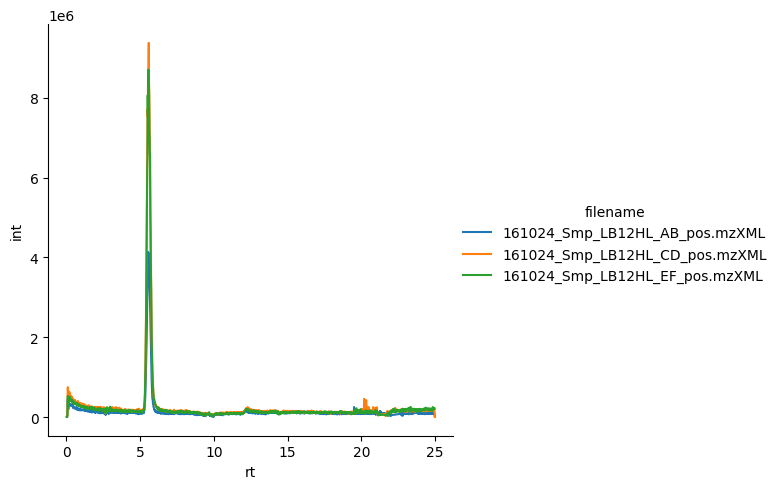

In [6]:
mz_window = msdata["MS1"][(msdata["MS1"]["mz"]>136.060) & (msdata["MS1"]["mz"]<136.063)]
sns.relplot(mz_window, kind="line", x="rt", y="int", hue="filename")

Looks like there's a pretty clear peak for adenine around the 6 minute mark that we can zoom in on by subsetting with respect to retention time and replotting:

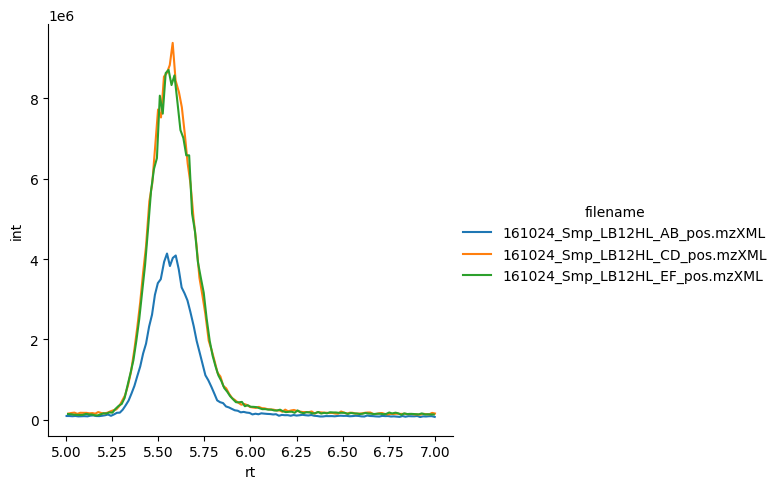

In [7]:
mz_window = mz_window[(mz_window["rt"]>5) & (mz_window["rt"]<7)]
sns.relplot(mz_window, kind="line", x="rt", y="int", hue="filename")

Which shows what adenine looks like in our environmental sample! You can find a list of many other compounds that are likely to be found in Ingalls Lab samples on the lab GitHub [here](https://github.com/IngallsLabUW/Ingalls_Standards/blob/master/Ingalls_Lab_Standards.csv).

### Untargeted MS techniques

Alternatively, we can use an *un*targeted approach that looks at the data without a priori knowledge of what compounds should be there. This allows for the discovery of novel compounds, or at least the detection and description of compounds that haven't been documented in the marine environment before. While there are more complicated ways of doing this (largely through the [OpenMS library](https://openms.readthedocs.io/en/latest/index.html)), a simple method is to look for high-intensity peak-shaped signals in the raw data. This method is how scientists in other labs discovered [gonyol](https://onlinelibrary.wiley.com/doi/10.1002/mbo3.1014) and [homoserine betaine](https://www.pnas.org/doi/full/10.1073/pnas.1611666113) in the marine environment, two molecules we now understand to be very important for organic carbon and sulfur cycling.


In [8]:
# Find the largest mass(es)
msdata["MS1"].sort_values("int", ascending=False).head()

,rt,mz,int,filename
5321850,9.636233,116.070641,895679872.0,161024_Smp_LB12HL_EF_pos.mzXML
841452,9.601733,116.070740,890746304.0,161024_Smp_LB12HL_AB_pos.mzXML
5320270,9.590467,116.070610,877354496.0,161024_Smp_LB12HL_EF_pos.mzXML
840943,9.586433,116.070724,870353920.0,161024_Smp_LB12HL_AB_pos.mzXML
840455,9.571433,116.070732,870034752.0,161024_Smp_LB12HL_AB_pos.mzXML


Since we happen to know what instrument collected this data, we already have a sense of the mass error associated (5-10 ppm). However, if you expand beyond data from the Ingalls Lab you'll have to determine this yourself by looking at how the *m/z* values change over the course of a chromatogram.

<ipython-input-9-d04ede08bce1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mz_window["int"] = np.log10(mz_window["int"])


<Axes: xlabel='rt', ylabel='mz'>

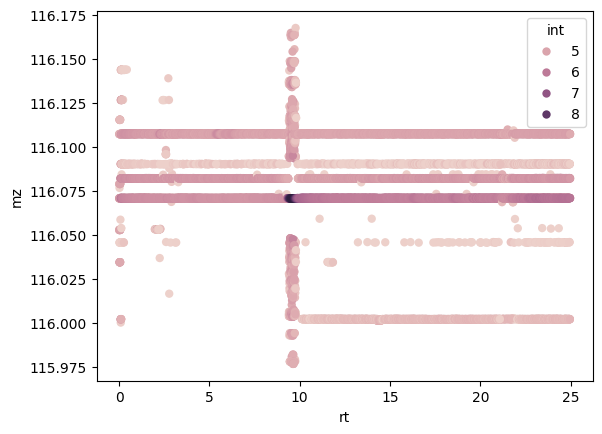

In [9]:
# Identify a (large) mass window around the largest mass to see m/z variance
mz_window = msdata["MS1"][(msdata["MS1"]["mz"]>116.070641-0.1) & (msdata["MS1"]["mz"]<116.070641+0.1)]
mz_window["int"] = np.log10(mz_window["int"])
mz_window = mz_window[mz_window["int"]>4]
sns.scatterplot(mz_window, x="rt", y="mz", hue="int", edgecolor='none')

The plot above shows a dark spot where the data's of especially high intensity around the expected mass. We can then zoom in on that horizontal "stripe" of data (corresponding to the associated chromatogram) and plot it to make sure the peak shape looks ok.

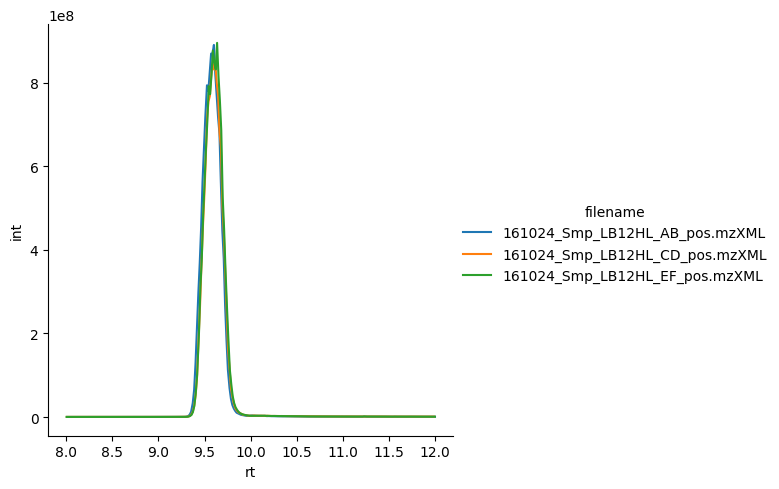

In [10]:
# Zoom in on specific mass trace
cmpd_window = msdata["MS1"][(msdata["MS1"]["mz"]>116.070) & (msdata["MS1"]["mz"]<116.075)]
cmpd_window = cmpd_window[(cmpd_window["rt"]>8) & (cmpd_window["rt"]<12)]
sns.relplot(cmpd_window, kind="line", x="rt", y="int", hue="filename")
plt.show()

Once we've identified a single, abundant molecule then we can begin to calculate information about it such as its exact mass, retention time, and peak area - all of which are useful when trying to determine what molecule it could be.

In [11]:
# Identify the molecule's exact mass
peak_data = cmpd_window[(cmpd_window["rt"]>9.4) & (cmpd_window["rt"]>9.8)]
exact_mass= peak_data["mz"].mean()
print(exact_mass)

116.07089781196197


With the exact mass in hand, we can use online tools such as https://www.chemcalc.org/mf-finder to see what combination of elements could produce a mass close to this. Plugging in our value from above and setting the maximum PPM to 10 returns two possible molecular formulae - $C_5H_{10}NO_2$ and $C_3H_8N_4O$. These formulae can then be [searched in databases such as Pubchem](https://pubchem.ncbi.nlm.nih.gov/#query=C5H9NO2) to learn that this molecule could be Proline or (N'-methylcarbamimidoyl)urea (remember that the calculated mass is for [M+H]$^+$, so we remove an H from the formula when searching it online). To narrow down the possibilities even further would require additional information such as [isotope patterns](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-8-105), [fragmentation data](https://en.wikipedia.org/wiki/Tandem_mass_spectrometry), or a priori knowledge of the environment in which the samples were found. For data generated by the Ingalls Lab though, a molecule that's not found in the [list of our standards](https://github.com/IngallsLabUW/Ingalls_Standards/blob/master/Ingalls_Lab_Standards.csv) is likely to be an unknown!

We end up with about 50-75% unknown molecules in our datasets which is a lot given the hundreds or thousands of signals. To narrow down which ones we want to spend time deducing a structure or formula, we often look for biological differences between treatments. To do this, we integrate the area of the peak because peak area (usually) has a linear correspondence with the concentration of the molecule in the sample: larger peak area, more concentrated compound. A simple sum is enough for a first order approximation of the area and is shown below.

In [12]:
# Calculate the molecule's peak area in each file
peak_data.groupby('filename')['int'].sum()

,int
filename,
161024_Smp_LB12HL_AB_pos.mzXML,2.692703e+08
161024_Smp_LB12HL_CD_pos.mzXML,3.769869e+08
161024_Smp_LB12HL_EF_pos.mzXML,3.639038e+08


This process of signal detection, visualization, and quantification can then be repeated for additional compounds in the dataset.

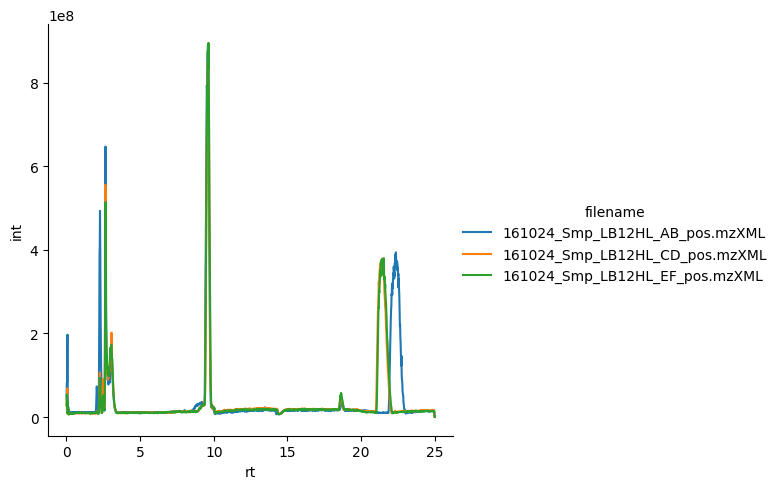

In [13]:
# Repeat for a different molecule! (The small one at 18 minutes)
sns.relplot(msdata["BPC"], kind="line", x="rt", y="int", hue="filename")

In [14]:
# Find the mass associated with the largest values in the 16-20 minute window
msdata["MS1"][(msdata["MS1"]["rt"]>16) & (msdata["MS1"]["rt"]<20)].sort_values("int", ascending=False).head()

,rt,mz,int,filename
6116650,18.631833,175.118744,57475408.0,161024_Smp_LB12HL_EF_pos.mzXML
6118881,18.662500,175.118790,55690604.0,161024_Smp_LB12HL_EF_pos.mzXML
6117783,18.647167,175.118820,55194616.0,161024_Smp_LB12HL_EF_pos.mzXML
6115495,18.616500,175.118774,53831880.0,161024_Smp_LB12HL_EF_pos.mzXML
6113184,18.585333,175.118851,51183804.0,161024_Smp_LB12HL_EF_pos.mzXML


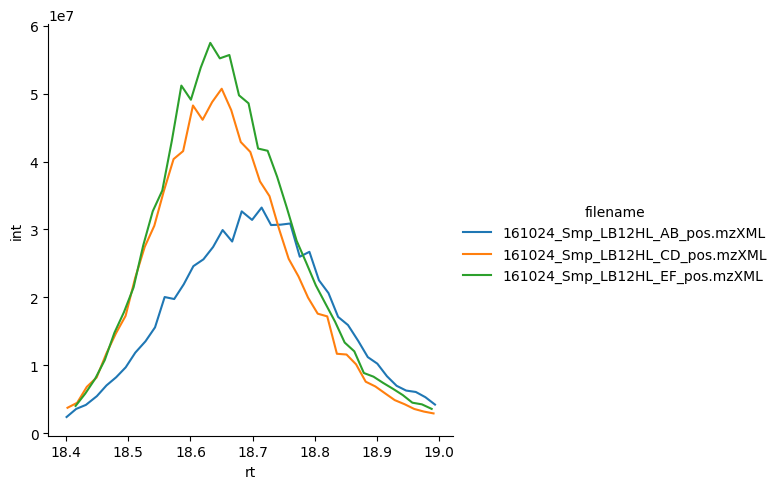

In [15]:
# Plot it to make sure we've got the right one and that we've got good retention time bounds
peak_data = msdata["MS1"][(msdata["MS1"]["mz"]>175.115) & (msdata["MS1"]["mz"]<175.120)]
peak_data = peak_data[(peak_data["rt"]>18.4) & (peak_data["rt"]<19)]
sns.relplot(peak_data, kind="line", x="rt", y="int", hue="filename")
plt.show()

In [16]:
# Areas are directly proportional to the molecule's concentration - larger area = larger concentration
peak_data.groupby('filename')['int'].sum()

,int
filename,
161024_Smp_LB12HL_AB_pos.mzXML,6.693758e+08
161024_Smp_LB12HL_CD_pos.mzXML,8.690094e+08
161024_Smp_LB12HL_EF_pos.mzXML,9.820439e+08


So far, I've only been showing data from a single treatment in the study. We can contrast the values we've gotten above with the values from the other treatments in the study broken down [here](https://www.ebi.ac.uk/metabolights/editor/MTBLS708/samples).

In [17]:
# Download and read in additional treatments!
!wget -O mzXML_data/161024_Smp_LB12LL_AB_pos.mzXML https://www.ebi.ac.uk/metabolights/ws/studies/MTBLS708/download/2dfa2656-ec75-4fe0-96ac-6b74f295b3e9?file=FILES/161024_Smp_LB12LL_AB_pos.mzXML
!wget -O mzXML_data/161024_Smp_LB12LL_CD_pos.mzXML https://www.ebi.ac.uk/metabolights/ws/studies/MTBLS708/download/2dfa2656-ec75-4fe0-96ac-6b74f295b3e9?file=FILES/161024_Smp_LB12LL_CD_pos.mzXML
!wget -O mzXML_data/161024_Smp_LB12LL_EF_pos.mzXML https://www.ebi.ac.uk/metabolights/ws/studies/MTBLS708/download/2dfa2656-ec75-4fe0-96ac-6b74f295b3e9?file=FILES/161024_Smp_LB12LL_EF_pos.mzXML
!wget -O mzXML_data/161024_Smp_RB12HL_AB_pos.mzXML https://www.ebi.ac.uk/metabolights/ws/studies/MTBLS708/download/2dfa2656-ec75-4fe0-96ac-6b74f295b3e9?file=FILES/161024_Smp_RB12HL_AB_pos.mzXML
!wget -O mzXML_data/161024_Smp_RB12HL_CD_pos.mzXML https://www.ebi.ac.uk/metabolights/ws/studies/MTBLS708/download/2dfa2656-ec75-4fe0-96ac-6b74f295b3e9?file=FILES/161024_Smp_RB12HL_CD_pos.mzXML
!wget -O mzXML_data/161024_Smp_RB12HL_EF_pos.mzXML https://www.ebi.ac.uk/metabolights/ws/studies/MTBLS708/download/2dfa2656-ec75-4fe0-96ac-6b74f295b3e9?file=FILES/161024_Smp_RB12HL_EF_pos.mzXML
!wget -O mzXML_data/161024_Smp_RB12LL_AB_pos.mzXML https://www.ebi.ac.uk/metabolights/ws/studies/MTBLS708/download/2dfa2656-ec75-4fe0-96ac-6b74f295b3e9?file=FILES/161024_Smp_RB12LL_AB_pos.mzXML
!wget -O mzXML_data/161024_Smp_RB12LL_CD_pos.mzXML https://www.ebi.ac.uk/metabolights/ws/studies/MTBLS708/download/2dfa2656-ec75-4fe0-96ac-6b74f295b3e9?file=FILES/161024_Smp_RB12LL_CD_pos.mzXML
!wget -O mzXML_data/161024_Smp_RB12LL_EF_pos.mzXML https://www.ebi.ac.uk/metabolights/ws/studies/MTBLS708/download/2dfa2656-ec75-4fe0-96ac-6b74f295b3e9?file=FILES/161024_Smp_RB12LL_EF_pos.mzXML

--2024-08-13 21:17:13--  https://www.ebi.ac.uk/metabolights/ws/studies/MTBLS708/download/2dfa2656-ec75-4fe0-96ac-6b74f295b3e9?file=FILES/161024_Smp_LB12LL_AB_pos.mzXML
Resolving www.ebi.ac.uk (www.ebi.ac.uk)... 193.62.193.80
Connecting to www.ebi.ac.uk (www.ebi.ac.uk)|193.62.193.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48393302 (46M) [application/octet-stream]
Saving to: ‘mzXML_data/161024_Smp_LB12LL_AB_pos.mzXML’

mzXML_data/161024_S 100%[===================>]  46.15M  5.98MB/s    in 6.0s    

2024-08-13 21:17:19 (7.74 MB/s) - ‘mzXML_data/161024_Smp_LB12LL_AB_pos.mzXML’ saved [48393302/48393302]

--2024-08-13 21:17:19--  https://www.ebi.ac.uk/metabolights/ws/studies/MTBLS708/download/2dfa2656-ec75-4fe0-96ac-6b74f295b3e9?file=FILES/161024_Smp_LB12LL_CD_pos.mzXML
Resolving www.ebi.ac.uk (www.ebi.ac.uk)... 193.62.193.80
Connecting to www.ebi.ac.uk (www.ebi.ac.uk)|193.62.193.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49

In [18]:
# Read in data and plot that last peak across all files
ms_files = ["mzXML_data/" + file for file in os.listdir("mzXML_data")]
msdata = pylgrams.grabMSdata(ms_files)
peak_data = msdata["MS1"][(msdata["MS1"]["mz"]>175.115) & (msdata["MS1"]["mz"]<175.120)]
peak_data = peak_data[(peak_data["rt"]>18.4) & (peak_data["rt"]<19)]

100%|██████████| 12/12 [00:13<00:00,  1.16s/it]


Total time: 13.91 seconds


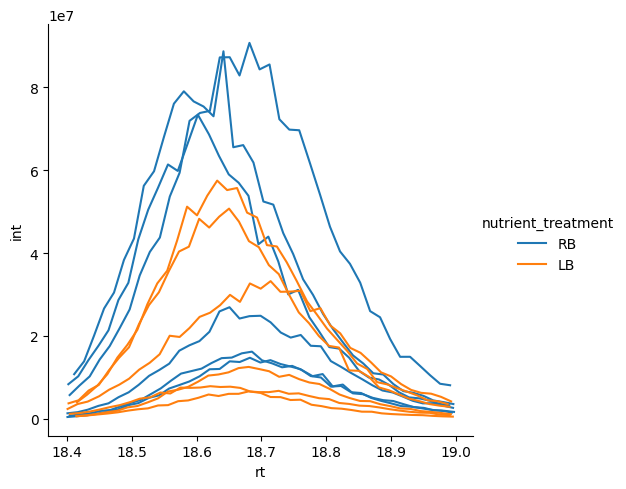

In [19]:
peak_data["nutrient_treatment"] = peak_data["filename"].str.extract(r'(RB|LB)')
peak_data["light_treatment"] = peak_data["filename"].str.extract(r'(HL|LL)')
sns.relplot(peak_data, kind="line", x="rt", y="int", hue="nutrient_treatment", units="filename", estimator=None)
plt.show()

<Axes: xlabel='light_treatment', ylabel='int'>

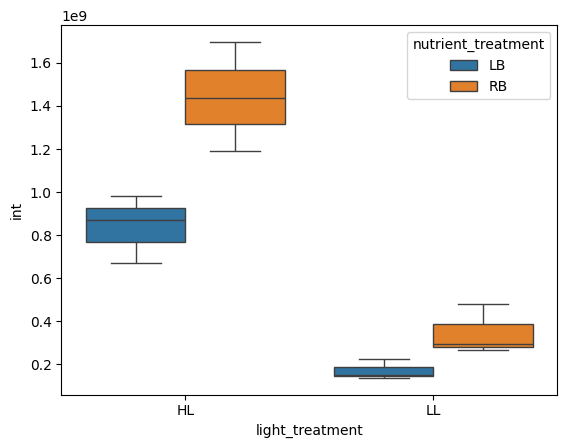

In [20]:
# Show areas as a boxplot
area_data = peak_data.groupby(['filename', 'light_treatment', 'nutrient_treatment'])['int'].sum().to_frame()
sns.boxplot(data=area_data, x="light_treatment", y="int", hue="nutrient_treatment")

This molecule shows clear differences between the high-light (HL) and low-light (LL) treatments, with a smaller difference between the nutrient replete (RB) and nutrient limiting (LB) treatments, making it an interesting candidate for additional effort to determine what its chemical formula and structure might be!